# Exercise 3: Shape Reconstruction

**Submission Deadline**: 13.06.2023, 23:55

We will take a look at two major approaches for 3D shape reconstruction in this last exercise.

Note that training reconstruction methods generally takes relatively long, even for simple shape completion. Training the generalization will take a few hours. **Thus, please make sure to start training well before the submission deadline.**

## 3.0. Running this notebook
We recommend running this notebook on a CUDA compatible local gpu. You can also run training on cpu, it will just take longer.

You have three options for running this exercise on a GPU, choose one of them and start the exercise below in section "Imports":
1. Locally on your own GPU
2. On our dedicated compute cluster
3. On Google Colab

We describe every option in more detail below:

---

### (a) Local Execution

If you run this notebook locally, you have to first install the python dependiencies again. They are the same as for exercise 1 so you can re-use the environment you used last time. If you use [poetry](https://python-poetry.org), you can also simply re-install everything (`poetry install`) and then run this notebook via `poetry run jupyter notebook`.

In case you are working with a RTX 3000-series GPU, you need to install a patched version of pytorch:

In [ ]:
%pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113

### (b) Compute Cluster

We provide access to a small compute cluster for the exercises and projects, consisting of a login node and 4 compute nodes with one dedicated RTX 3090 GPU each.
Please send us a short email with your name and preferred username so we can add you as a user.

We uploaded a PDF to Moodle with detailed information on how to access and use the cluster.

Since the cluster contains RTX 3000-series GPUs, you will need to install a patched version of pytorch:

In [ ]:
%pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113

### (c) Google Colab

If you don't have access to a GPU and don't want to use our cluster, you can also use Google Colab. However, we experienced the issue that inline visualization of shapes or inline images didn't work on colab, so just keep that in mind.
What you can also do is only train networks on colab, download the checkpoint, and visualize inference locally.

In case you're using Google Colab, you can upload the exercise folder (containing `exercise_2.ipynb`, directory `exercise_2` and the file `requirements.txt`) as `3d-machine-learning` to google drive (make sure you don't upload extracted datasets files).
Additionally you'd need to open the notebook `exercise_2.ipynb` in Colab using `File > Open Notebook > Upload`.

Next you'll need to run these two cells for setting up the environment. Before you do that make sure your instance has a GPU.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# We assume you uploaded the exercise folder in root Google Drive folder

!cp -r /content/drive/MyDrive/3d-machine-learning 3d-machine-learning/
os.chdir('/content/3d-machine-learning/')
print('Installing requirements')
%pip install -r requirements.txt

# Make sure you restart runtime when directed by Colab

Run this cell after restarting your colab runtime

In [ ]:
import os
import sys
import torch
os.chdir('/content/3d-machine-learning/')
sys.path.insert(1, "/content/3d-machine-learning/")
print('CUDA availability:', torch.cuda.is_available())

---

### Imports

The following imports should work regardless of whether you are using Colab or local execution.

### Imports

The following imports should work regardless of whether you are using Colab or local execution.

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import matplotlib as plt
import k3d
import trimesh
import torch
import skimage

Use the next cell to test whether a GPU was detected by pytorch.

In [2]:
torch.cuda.is_available()

True

## 3.1 Shape Reconstruction from 3D SDF grids with 3D-EPN

In the first part of this exercise, we will take a look at shape complation using [3D-EPN](https://arxiv.org/abs/1612.00101). This approach was also introduced in the lecture.

The visualization below shows an overview of the method: From an incomplete shape observation (which you would get when scanning an object with a depth sensor for example), we use a 3D encoder-predictor network that first encodes the incomplete shapes into a common latent space using several 3D convolution layers and then decodes them again using multiple 3D transpose convolutions.

This way, we get from a 32^3 SDF voxel grid to a 32^3 DF (unsigned) voxel grid that represents the completed shape. We only focus on this part here; in the original implementation, this 32^3 completed prediction would then be further improved (in an offline step after inference) by sampling parts from a shape database to get the final resolution to 128^3.

<img src="exercise_3/images/3depn_teaser.png" alt="3D-EPN Teaser" style="width: 800px;"/>

The next steps will follow the structure we established in exercise 2: Taking a look at the dataset structure and downloading the data; then, implementing dataset, model, and training loop.

### (a) Downloading the data
We will use the original dataset used in the official implementation. It consists of SDF and DF grids (representing incomplete input data and complete target data) with a resolution of 32^3 each. Each input-target pair is generated from a ShapeNet shape.

The incomplete SDF data are generated by sampling virtual camera trajectories around every object. Each trajectory is assigned an ID which is part of the file names (see below). The camera views for each trajectory are combined into a common SDF grid by volumetric fusion. It is easy to generate an SDF here since we know both camera location and object surface: Everything between camera and surface is known free space and outside the object, leading to a positive SDF sign. Everything behind the surface has a negative sign. For the complete shapes, however, deciding whether a voxel in the DF grid is inside or outside an object is not a trivial problem. This is why we use unsigned distance fields as target and prediction representation instead. This still encodes the distance to the closest surface but does not contain explicit information about the inside/outside location.

In terms of dataset layout, we follow the ShapeNet directory structure as seen in the last exercise:
Each folder in the `exercise_3/data/shapenet_dim32_sdf` and `exercise_3/data/shapenet_dim32_df` directories contains one shape category represented by a number, e.g. `02691156`.
We provide the mapping between these numbers and the corresponding names in `exercise_3/data/shape_info.json`. Each of these shape category folders contains lots of shapes in sdf or df format. In addition to that, every shape now also contains multiple trajectories: 0 to 7, encoded as `__0__` to `__7__`. These 8 files are just different input representations, meaning they vary in the level of completeness and location of missing parts; they all map to the `.df` file with corresponding shape ID and `__0__` at the end.

```
# contents of exercise_2/data/shapenet_dim32_sdf
02691156/                                           # Shape category folder with all its shapes
    ├── 10155655850468db78d106ce0a280f87__0__.sdf   # Trajectory 0 for a shape of the category
    ├── 10155655850468db78d106ce0a280f87__1__.sdf   # Trajectory 1 for the same shape
    ├── :                                      
    ├── 10155655850468db78d106ce0a280f87__7__.sdf   # Trajectory 7 for the same shape
    ├── 10155655850468db78d106ce0a280f87__0__.sdf   # Trajectory 0 for another shape
    ├── :                                           # And so on ...
02933112/                                           # Another shape category folder
02958343/                                           # In total you should have 8 shape category folders
:

# contents of exercise_2/data/shapenet_dim32_df
02691156/                                           # Shape category folder with all its shapes
    ├── 10155655850468db78d106ce0a280f87__0__.df    # A single shape of the category
    ├── 1021a0914a7207aff927ed529ad90a11__0__.df    # Another shape of the category
    ├── :                                           # And so on ...
02933112/                                           # Another shape category folder
02958343/                                           # In total you should have 55 shape category folders
:
```

Download and extract the data with the code cell below.

**Note**: If you are training on Google Colab and are running out of disk space, you can do the following:
- Only download the zip files below without extracting them (comment out all lines after `print('Extracting ...')`)
- Change `from exercise_3.data.shapenet import ShapeNet` to `from exercise_3.data.shapenet_zip import ShapeNet`
- Implement your dataset in `shapenet_zip.py`. This implementation extracts the data on-the-fly without taking up any additional disk space. Your training will therefore run a bit slower.
- Make sure you uncomment the lines setting the worker_init_fn in `train_3depn.py` (marked with TODOs)

In [ ]:
print('Downloading ...')
# File sizes: 11GB for shapenet_dim32_sdf.zip (incomplete scans), 4GB for shapenet_dim32_df.zip (target shapes)
!wget http://kaldir.vc.in.tum.de/adai/CNNComplete/shapenet_dim32_sdf.zip -P exercise_3/data
!wget http://kaldir.vc.in.tum.de/adai/CNNComplete/shapenet_dim32_df.zip -P exercise_3/data
print('Extracting ...')
!unzip -q exercise_3/data/shapenet_dim32_sdf.zip -d exercise_3/data
!unzip -q exercise_3/data/shapenet_dim32_df.zip -d exercise_3/data
!rm exercise_3/data/shapenet_dim32_sdf.zip
!rm exercise_3/data/shapenet_dim32_df.zip
print('Done.')

### (b) Dataset

The dataset implementation follows the same general structure as in exercise 2. We prepared an initial implementation already in `exercise_3/data/shapenet.py`; your task is to resolve all TODOs there.

The data for SDFs and DFs in `.sdf`/`.df` files are stored in binary form as follows:
```
dimX    #uint64 
dimY    #uint64 
dimZ    #uint64 
data    #(dimX*dimY*dimZ) floats for sdf/df values
```
The SDF values stored per-voxel represent the distance to the closest surface *in voxels*.

You have to take care of three important steps before returning the SDF and DF for the corresponding `index` in `__getitem__`:
1. **Truncation**: 3D-EPN uses a truncated SDF which means that for each voxel, the distance to the closest surface will be clamped to a max absolute value. This is helpful since we do not care about longer distances (Marching Cubes only cares about distances close to the surface). It allows us to focus our predictions on the voxels near the surface. We use a `truncation_distance` of 3 (voxels) which means we expect to get an SDF with values between -3 and 3 as input to the model.
2. **Separation** of distances and sign: 3D-EPN uses as input a 2x32x32x32 SDF grid, with absolute distance values of the SDF in channel 0 and the signs (-1 or 1) in channel 1.
3. **Log** scaling: We scale targets and prediction with a log operation to further guide predictions to focus on the surface voxels. Therefore, you should return target DFs as `log(df + 1)`.

**Hint**: An easy way to load the data from `.sdf` and `.df` files is to use `np.fromfile`. First, load the dimensions, then the data, then reshape everything into the shape you loaded in the beginning. Make sure you get the datatypes and byte offsets right! If you are using the zip version of the dataset as explained above, you should use `np.frombuffer` instead of `np.fromfile` to load from the `data`-buffer. The syntax is identical.

In [ ]:
from exercise_3.data.shapenet import ShapeNet

# Create a dataset with train split
train_dataset = ShapeNet('train')
val_dataset = ShapeNet('val')
overfit_dataset = ShapeNet('overfit')

# Get length, which is a call to __len__ function
print(f'Length of train set: {len(train_dataset)}')  # expected output: 153540
# Get length, which is a call to __len__ function
print(f'Length of val set: {len(val_dataset)}')  # expected output: 32304
# Get length, which is a call to __len__ function
print(f'Length of overfit set: {len(overfit_dataset)}')  # expected output: 64

In [ ]:
# Visualize some shapes
from exercise_3.util.visualization import visualize_mesh
from skimage.measure import marching_cubes

train_sample = train_dataset[1]
print(f'Name: {train_sample["name"]}')  # expected output: 03001627/798a46965d9e0edfcea003eff0268278__3__-03001627/798a46965d9e0edfcea003eff0268278__0__
print(f'Input SDF: {train_sample["input_sdf"].shape}')  # expected output: (2, 32, 32, 32)
print(f'Target DF: {train_sample["target_df"].shape}')  # expected output: (32, 32, 32)

input_mesh = marching_cubes(train_sample['input_sdf'][0], level=1)
visualize_mesh(input_mesh[0], input_mesh[1], flip_axes=True)

In [ ]:
train_sample = train_dataset[223]
print(f'Name: {train_sample["name"]}')  # expected output: 04379243/a1be21c9a71d133dc5beea20858a99d5__5__-04379243/a1be21c9a71d133dc5beea20858a99d5__0__
print(f'Input SDF: {train_sample["input_sdf"].shape}')  # expected output: (2, 32, 32, 32)
print(f'Target DF: {train_sample["target_df"].shape}')  # expected output: (32, 32, 32)

input_mesh = marching_cubes(train_sample['input_sdf'][0], level=1)
visualize_mesh(input_mesh[0], input_mesh[1], flip_axes=True)

In [ ]:
train_sample = train_dataset[95]
print(f'Name: {train_sample["name"]}')  # expected output: 03636649/3889631e42a84b0f51f77a6d7299806__2__-03636649/3889631e42a84b0f51f77a6d7299806__0__
print(f'Input SDF: {train_sample["input_sdf"].shape}')  # expected output: (2, 32, 32, 32)
print(f'Target DF: {train_sample["target_df"].shape}')  # expected output: (32, 32, 32)

input_mesh = marching_cubes(train_sample['input_sdf'][0], level=1)
visualize_mesh(input_mesh[0], input_mesh[1], flip_axes=True)

### (c) Model

The model architecture of 3D-EPN is visualized below:

<img src="exercise_3/images/3depn.png" alt="3D-EPN Architecture" style="width: 800px;"/>

For this exercise, we simplify the model by omitting the classification part - this will not have a big impact since most of the shape completion performance comes from the 3D encoder-decoder unet.

The model consists of three parts: The encoder, the bottleneck, and the decoder. Encoder and decoder are constructed with the same architecture, just mirrored.

The details of each part are:
- **Encoder**: 4 layers, each one containing a 3D convolution (with kernel size 4, as seen in the visualization), a 3D batch norm (except the very first layer), and a leaky ReLU with a negative slope of 0.2. Our goal is to reduce the spatial dimension from 32x32x32 to 1x1x1 and to get the feature dimension from 2 (absolute values and sign) to `num_features * 8`. We do this by using a stride of 2 and padding of 1 for all convolutions except for the last one where we use a stride of 1 and no padding. The feature channels are increased from 2 to `num_features` in the first layer and then doubled with every subsequent layer.
- **Decoder**: Same architecture as encoder, just mirrored: Going from `num_features * 8 * 2` (the 2 will be explained later) to 1 (the DF values). The spatial dimensions go from 1x1x1 to 32x32x32. Each layer use a 3D Transpose convolution now, together with 3D batch norm and ReLU (no leaky ReLUs anymore). Note that the last layer uses neither Batch Norms nor a ReLU since we do not want to constrain the range of possible values for the prediction.
- **Bottleneck**: This is realized with 2 fully connected layers, each one going from a vector of size 640 (which is `num_features * 8`) to a vector of size 640. Each such layer is followed by a ReLU activation.

Some minor details:
- **Skip connections** allow the decoder to use information from the encoder and also improve gradient flow. We use it here to connect the output of encoder layer 1 to decoder layer 4, the output of encoder layer 2 to decoder layer 3, and so on. This means that the input to a decoder layer is the concatenation of the previous decoder output with the corresponding encoder output, along the feature dimension. Hence, the number of input features for each decoder layer are twice those of the encoder layers, as mentioned above.
- **Log scaling**: You also need to scale the final outputs of the network logarithmically: `out = log(abs(out) + 1)`. This is the same transformation you applied to the target shapes in the dataloader before and ensures that prediction and target volumes are comparable.

With this in mind, implement the network architecture and `forward()` function in `exercise_3/model/threedepn.py`. You can check your architecture with the cell below.

In [ ]:
from exercise_3.model.threedepn import ThreeDEPN
from exercise_3.util.model import summarize_model

threedepn = ThreeDEPN()
print(summarize_model(threedepn))  # Expected: Rows 0-34 and TOTAL = 52455681

sdf = torch.randn(4, 1, 32, 32, 32) * 2. - 1.
input_tensor = torch.cat([torch.abs(sdf), torch.sign(sdf)], dim=1)
predictions = threedepn(input_tensor)

print('Output tensor shape: ', predictions.shape)  # Expected: torch.Size([4, 32, 32, 32])

### (d) Training script and overfitting to a single shape reconstruction

You can now go to the train script in `exercise_3/training/train_3depn.py` and fill in the missing pieces as you did for exercise 2. Then, verify that your training work by overfitting to a few samples below.

In [ ]:
from exercise_3.training import train_3depn
config = {
    'experiment_name': '3_1_3depn_overfitting',
    'device': 'cuda:0',  # change this to cpu if you do not have a GPU
    'is_overfit': True,
    'batch_size': 32,
    'resume_ckpt': None,
    'learning_rate': 0.001,
    'max_epochs': 250,
    'print_every_n': 10,
    'validate_every_n': 25,
}
train_3depn.main(config)  # should be able to get <0.0025 train_loss and <0.13 val_loss

### (e) Training over the entire training set
If the overfitting works, we can go ahead with training on the entire dataset.

**Note**: As is the case with most reconstruction networks and considering the size of the model (> 50M parameters), this training will take a few hours on a GPU. *Please make sure to start training early enough before the submission deadline.*

In [ ]:
config = {
    'experiment_name': '3_1_3depn_generalization',
    'device': 'cuda:0',  # change this to cpu if you do not have a GPU
    'is_overfit': False,
    'batch_size': 32,
    'resume_ckpt': None,
    'learning_rate': 0.001,
    'max_epochs': 5,
    'print_every_n': 50,
    'validate_every_n': 1000,
}
train_3depn.main(config)  # should be able to get best_loss_val < 0.1 after a few hours and 5 epochs

### (f) Inference

Implement the missing bits in `exercise_3/inference/infer_3depn.py`. You should then be able to see your reconstructions below.

The outputs of our provided visualization functions are, from left to right:
- Input, partial shape
- Predicted completion
- Target shape

In [ ]:
from exercise_3.util.visualization import visualize_meshes
from exercise_3.inference.infer_3depn import InferenceHandler3DEPN

# create a handler for inference using a trained checkpoint
inferer = InferenceHandler3DEPN('exercise_3/runs/3_1_3depn_generalization/model_best.ckpt')

In [ ]:
input_sdf = ShapeNet.get_shape_sdf('03636649/b286c9c136784db2af1744fdb1fbe7df__0__')
target_df = ShapeNet.get_shape_df('03636649/b286c9c136784db2af1744fdb1fbe7df__0__')

input_mesh, reconstructed_mesh, target_mesh = inferer.infer_single(input_sdf, target_df)
visualize_meshes([input_mesh, reconstructed_mesh, target_mesh], flip_axes=True)

In [ ]:
input_sdf = ShapeNet.get_shape_sdf('03636649/23eaba9bdd51a5b0dfe9cab879fd37e8__1__')
target_df = ShapeNet.get_shape_df('03636649/23eaba9bdd51a5b0dfe9cab879fd37e8__0__')

input_mesh, reconstructed_mesh, target_mesh = inferer.infer_single(input_sdf, target_df)
visualize_meshes([input_mesh, reconstructed_mesh, target_mesh], flip_axes=True)

In [ ]:
input_sdf = ShapeNet.get_shape_sdf('02691156/5de2cc606b65b960e0b6546e08902f28__0__')
target_df = ShapeNet.get_shape_df('02691156/5de2cc606b65b960e0b6546e08902f28__0__')

input_mesh, reconstructed_mesh, target_mesh = inferer.infer_single(input_sdf, target_df)
visualize_meshes([input_mesh, reconstructed_mesh, target_mesh], flip_axes=True)

## 3.2 DeepSDF


Here, we will take a look at 3D-reconstruction using [DeepSDF](https://arxiv.org/abs/1901.05103). We recommend reading the paper before attempting the exercise.

DeepSDF is an auto-decoder based approach that learns a continuous SDF representation for a class of shapes. Once trained, it can be used for shape representation, interpolation and shape completion. We'll look at each of these
applications.

<img src="exercise_3/images/deepsdf_teaser.png" alt="deepsdf_teaser" style="width: 800px;"/>

During training, the autodecoder optimizes both the network parameters and the latent codes representing each of the training shapes. Once trained, to reconstruct a shape given its SDF observations, a latent code is
optimized keeping the network parameters fixed, such that the optimized latent code gives the lowest error with observed SDF values.

An advantage that implicit representations have over voxel/grid based approaches is that they are not tied to a particular grid resolution, and can be evaluated at any resolution once trained.

Similar to previous exercise, we'll first download the processed dataset, look at the implementation of the dataset, the model and the trainer, try out overfitting and generalization over the entire dataset, and finally inference on unseen samples.

### (a) Downloading the data

Whereas volumetric models output entire 3d shape representations, implicit models like DeepSDF work on per point basis. The network takes in a 3D-coordinate (and additionally the latent vector) and outputs the SDF value at the queried point. To train such a model,
we therefore need, for each of the training shapes, a bunch of points with their corresponding SDF values for supervision. Points are sampled more aggressively near the surface of the object as we want to capture a more detailed SDF near the surface. For those curious,
data preparation is decribed in more detail in section 5 of the paper.

We'll be using the ShapeNet Sofa class for the experiments in this exercise. We've already prepared this data, so that you don't need to deal with the preprocessing. For each shape, the following files are provided:
- `mesh.obj` representing the mesh representation of the shape
- `sdf.npz` file containing large number of points sampled on and around the mesh and their sdf values; contains numpy arrays under keys "pos" and "neg", containing points with positive and negative sdf values respectively

```
# contents of exercise_3/data/sdf_sofas
1faa4c299b93a3e5593ebeeedbff73b/                    # shape 0
    ├── mesh.obj                                    # shape 0 mesh
    ├── sdf.npz                                     # shape 0 sdf
    ├── surface.obj                                 # shape 0 surface
1fde48d83065ef5877a929f61fea4d0/                    # shape 1
1fe1411b6c8097acf008d8a3590fb522/                   # shape 2
:
```
Download and extract the data with the code cell below.

In [ ]:
print('Downloading ...')
# File sizes: ~10GB
!wget https://www.dropbox.com/s/4k5pw126nzus8ef/sdf_sofas.zip\?dl\=0 -O exercise_3/data/sdf_sofas.zip -P exercise_3/data

print('Extracting ...')
!unzip -q exercise_3/data/sdf_sofas.zip -d exercise_3/data
!rm exercise_3/data/sdf_sofas.zip

print('Done.')

### (b) Dataset

We provide a partial implementation of the dataset in `exercise_3/data/shape_implicit.py`.
Your task is to complete the `#TODOs` so that the dataset works as specified by the docstrings.

Once done, you can try running the following code blocks as sanity checks.

In [3]:
from exercise_3.data.shape_implicit import ShapeImplicit

num_points_to_samples = 40000
train_dataset = ShapeImplicit(num_points_to_samples, "train")
val_dataset = ShapeImplicit(num_points_to_samples, "val")
overfit_dataset = ShapeImplicit(num_points_to_samples, "overfit")

# Get length, which is a call to __len__ function
print(f'Length of train set: {len(train_dataset)}')  # expected output: 1226
# Get length, which is a call to __len__ function
print(f'Length of val set: {len(val_dataset)}')  # expected output: 137
# Get length, which is a call to __len__ function
print(f'Length of overfit set: {len(overfit_dataset)}')  # expected output: 1

Length of train set: 1226
Length of val set: 137
Length of overfit set: 1


Let's take a look at the points sampled for a particular shape.

In [4]:
from exercise_3.util.visualization import visualize_mesh, visualize_pointcloud

shape_id = train_dataset[0]['name']
points = train_dataset[0]['points']
sdf = train_dataset[0]['sdf']

# sampled points inside the shape
inside_points = points[sdf[:, 0] < 0, :].numpy()

# sampled points outside the shape
outside_points = points[sdf[:, 0] > 0, :].numpy()

In [5]:
mesh = ShapeImplicit.get_mesh(shape_id)
print('Mesh')
visualize_mesh(mesh.vertices, mesh.faces, flip_axes=True)

Mesh


C:\Users\emret\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Output()

In [6]:
print('Sampled points with negative SDF (inside)')
visualize_pointcloud(inside_points, 0.025, flip_axes=True)

Sampled points with negative SDF (inside)


Output()

In [7]:
print('Sampled points with positive SDF (outside)')
visualize_pointcloud(outside_points, 0.025, flip_axes=True)

Sampled points with positive SDF (outside)


Output()

You'll notice that more points are sampled close to the surface rather than away from the surface.

### (c) Model

The DeepSDF auto-decoder architecture is visualized below:

<img src="exercise_3/images/deepsdf_architecture.png" alt="deepsdf_arch" style="width: 640px;"/>

Things to note:

- The network takes in the latent code for a shape concatenated with the query 3d coordinate, making up a 259 length vector (assuming latent code length is 256).
- The network consist of a sequence of weight-normed linear layers, each followed by a ReLU and a dropout. For weight norming a layer, check out `torch.nn.utils.weight_norm`. Each of these linear layers outputs a 512 dimensional vector, except the 4th layer which outputs a 253 dimensional vector.
- The output of the 4th layer is concatenated with the input, making the input to the 5th layer a 512 dimensional vector.
- The final layer is a simple linear layer without any norm, dropout or non-linearity, with a single dimensional output representing the SDF value.

Implement this architecture in file `exercise_3/model/deepsdf.py`.

Here are some basic sanity tests once you're done with your implementation.

In [8]:
from exercise_3.model.deepsdf import DeepSDFDecoder
from exercise_3.util.model import summarize_model

deepsdf = DeepSDFDecoder(latent_size=256)
print(summarize_model(deepsdf))

# input to the network is a concatenation of point coordinates (3) and the latent code (256 in this example);
# here we use a batch of 4096 points
input_tensor = torch.randn(4096, 3 + 256)
predictions = deepsdf(input_tensor)

print('\nOutput tensor shape: ', predictions.shape)  # expected output: 4096, 1

num_trainable_params = sum(p.numel() for p in deepsdf.parameters() if p.requires_grad) / 1e6
print(f'\nNumber of traininable params: {num_trainable_params:.2f}M')  # expected output: ~1.8M

   | Name    | Type           | Params 
---------------------------------------------
0  | lin1    | Sequential     | 1053178
1  | lin1.0  | Linear         | 133632 
2  | lin1.1  | ReLU           | 0      
3  | lin1.2  | Dropout        | 0      
4  | lin1.3  | Linear         | 263168 
5  | lin1.4  | ReLU           | 0      
6  | lin1.5  | Dropout        | 0      
7  | lin1.6  | Linear         | 263168 
8  | lin1.7  | ReLU           | 0      
9  | lin1.8  | Dropout        | 0      
10 | lin1.9  | Linear         | 263168 
11 | lin1.10 | ReLU           | 0      
12 | lin1.11 | Dropout        | 0      
13 | lin1.12 | Linear         | 130042 
14 | lin1.13 | ReLU           | 0      
15 | lin1.14 | Dropout        | 0      
16 | lin2    | Sequential     | 1053185
17 | lin2.0  | Linear         | 263168 
18 | lin2.1  | ReLU           | 0      
19 | lin2.2  | Dropout        | 0      
20 | lin2.3  | Linear         | 263168 
21 | lin2.4  | ReLU           | 0      
22 | lin2.5  | Dropout        | 0 

### (d) Training script and overfitting to a single shape

Fill in the train script in `exercise_3/training/train_deepsdf.py`, and verify that your training work by overfitting to a few samples below.

In [9]:
from exercise_3.training import train_deepsdf

overfit_config = {
    'experiment_name': '3_2_deepsdf_overfit',
    'device': 'cuda:0',  # change this to cpu if you do not have a GPU
    'is_overfit': True,
    'num_sample_points': 4096,
    'latent_code_length': 256,
    'batch_size': 1,
    'resume_ckpt': None,
    'learning_rate_model': 0.0005,
    'learning_rate_code': 0.001,
    'lambda_code_regularization': 0.0001,
    'max_epochs': 2000,
    'print_every_n': 50,
    'visualize_every_n': 250,
}

train_deepsdf.main(overfit_config)  # expected loss around 0.0062

Using device: cuda:0
[049/00000] train_loss: 0.002114
[099/00000] train_loss: 0.000978
[149/00000] train_loss: 0.000617
[199/00000] train_loss: 0.000428
[249/00000] train_loss: 0.000352
[299/00000] train_loss: 0.000299
[349/00000] train_loss: 0.000267
[399/00000] train_loss: 0.000246
[449/00000] train_loss: 0.000224
[499/00000] train_loss: 0.000206
[549/00000] train_loss: 0.000190
[599/00000] train_loss: 0.000183
[649/00000] train_loss: 0.000178
[699/00000] train_loss: 0.000171
[749/00000] train_loss: 0.000166
[799/00000] train_loss: 0.000162
[849/00000] train_loss: 0.000155
[899/00000] train_loss: 0.000152
[949/00000] train_loss: 0.000147
[999/00000] train_loss: 0.000142
[1049/00000] train_loss: 0.000138
[1099/00000] train_loss: 0.000135
[1149/00000] train_loss: 0.000134
[1199/00000] train_loss: 0.000131
[1249/00000] train_loss: 0.000130
[1299/00000] train_loss: 0.000128
[1349/00000] train_loss: 0.000126
[1399/00000] train_loss: 0.000125
[1449/00000] train_loss: 0.000122
[1499/00000] 

Let's visualize the overfitted shape reconstruction to check if it looks reasonable.

In [10]:
# Load and visualize GT mesh of the overfit sample
gt_mesh = ShapeImplicit.get_mesh('7e728818848f191bee7d178666aae23d')
print('GT')
visualize_mesh(gt_mesh.vertices, gt_mesh.faces, flip_axes=True)

# Load and visualize reconstructed overfit sample; it's okay if they don't look visually exact, since we don't run 
# the training too long and have a learning rate decay while training 
mesh_path = "exercise_3/runs/3_2_deepsdf_overfit/meshes/01999_000.obj"
overfit_output = trimesh.load(mesh_path)
print('Overfit')
visualize_mesh(overfit_output.vertices, overfit_output.faces, flip_axes=True)

GT


Output()

Overfit


Output()

### (e) Training over entire train set

Once overfitting works, we can train on the entire train set.

Note: This training will take a few hours on a GPU (took ~3 hrs for 500 epochs on our 2080Ti, which already gave decent results). Please make sure to start training early enough before the submission deadline.

In [11]:
from exercise_3.training import train_deepsdf

generalization_config = {
    'experiment_name': '3_2_deepsdf_generalization',
    'device': 'cuda:0',  # run this on a gpu for a reasonable training time
    'is_overfit': False,
    'num_sample_points': 4096, # you can adjust this such that the model fits on your gpu
    'latent_code_length': 256,
    'batch_size': 1,
    'resume_ckpt': None,
    'learning_rate_model': 0.0005,
    'learning_rate_code': 0.001,
    'lambda_code_regularization': 0.0001,
    'max_epochs': 2000,  # not necessary to run for 2000 epochs if you're short on time, at 500 epochs you should start to see reasonable results
    'print_every_n': 50,
    'visualize_every_n': 5000,
}

train_deepsdf.main(generalization_config)

Using device: cuda:0
[000/00049] train_loss: 0.002366
[000/00099] train_loss: 0.002139
[000/00149] train_loss: 0.002030
[000/00199] train_loss: 0.001910
[000/00249] train_loss: 0.001826
[000/00299] train_loss: 0.001817
[000/00349] train_loss: 0.001935
[000/00399] train_loss: 0.001841
[000/00449] train_loss: 0.001798
[000/00499] train_loss: 0.001840
[000/00549] train_loss: 0.001889
[000/00599] train_loss: 0.001832
[000/00649] train_loss: 0.001812
[000/00699] train_loss: 0.001690
[000/00749] train_loss: 0.001914
[000/00799] train_loss: 0.001834
[000/00849] train_loss: 0.001849
[000/00899] train_loss: 0.001751
[000/00949] train_loss: 0.001713
[000/00999] train_loss: 0.001850
[000/01049] train_loss: 0.001803
[000/01099] train_loss: 0.001680
[000/01149] train_loss: 0.001690
[000/01199] train_loss: 0.001695
[001/00023] train_loss: 0.001729
[001/00073] train_loss: 0.001699
[001/00123] train_loss: 0.001663
[001/00173] train_loss: 0.001692
[001/00223] train_loss: 0.001667
[001/00273] train_loss

KeyboardInterrupt: 

### (f) Inference using the trained model on observed SDF values

Fill in the inference script `exercise_3/inference/infer_deepsdf.py`. Note that it's not simply a forward pass, but an optimization of the latent code such that we have lowest error on observed SDF values.

In [12]:
from exercise_3.inference.infer_deepsdf import InferenceHandlerDeepSDF

device = torch.device('cuda:0')  # change this to cpu if you're not using a gpu

inference_handler = InferenceHandlerDeepSDF(256, "exercise_3/runs/3_2_deepsdf_generalization", device)

First, we try inference on a shape from validation set, for which we have a complete observation of sdf values. This is an easier problem as compared to shape completion,
since we have all the information already in the input.

Let's visualize the observations.

In [13]:
# get observed data
points, sdf = ShapeImplicit.get_all_sdf_samples("b351e06f5826444c19fb4103277a6b93")

inside_points = points[sdf[:, 0] < 0, :].numpy()
outside_points = points[sdf[:, 0] > 0, :].numpy()

# visualize observed points; you'll observe that the observations are very complete
print('Observations with negative SDF (inside)')
visualize_pointcloud(inside_points, 0.025, flip_axes=True)
print('Observations with positive SDF (outside)')
visualize_pointcloud(outside_points, 0.025, flip_axes=True)

Observations with negative SDF (inside)


Output()

Observations with positive SDF (outside)


Output()

Reconstruction on these observations with the trained model:

In [14]:
# reconstruct
vertices, faces = inference_handler.reconstruct(points, sdf, 800)
# visualize
visualize_mesh(vertices, faces, flip_axes=True)

[00000] optim_loss: 0.001607
[00050] optim_loss: 0.000108
[00100] optim_loss: 0.000071
[00150] optim_loss: 0.000056
[00200] optim_loss: 0.000052
[00250] optim_loss: 0.000053
[00300] optim_loss: 0.000048
[00350] optim_loss: 0.000049
[00400] optim_loss: 0.000049
[00450] optim_loss: 0.000045
[00500] optim_loss: 0.000043
[00550] optim_loss: 0.000047
[00600] optim_loss: 0.000050
[00650] optim_loss: 0.000050
[00700] optim_loss: 0.000047
[00750] optim_loss: 0.000050
Optimization complete.


Output()

Next, we can try the shape completion task, i.e., inference on a shape from validation set, for which we do not have a complete observation of sdf values. The observed points are visualized below:

In [15]:
# get observed data
points, sdf = ShapeImplicit.get_all_sdf_samples("b351e06f5826444c19fb4103277a6b93_incomplete")

inside_points = points[sdf[:, 0] < 0, :].numpy()
outside_points = points[sdf[:, 0] > 0, :].numpy()

# visualize observed points; you'll observe that the observations are incomplete
# making this is a shape completion task
print('Observations with negative SDF (inside)')
visualize_pointcloud(inside_points, 0.025, flip_axes=True)
print('Observations with positive SDF (outside)')
visualize_pointcloud(outside_points, 0.025, flip_axes=True)

Observations with negative SDF (inside)


Output()

Observations with positive SDF (outside)


Output()

Shape completion using the trained model:

In [16]:
# reconstruct
vertices, faces = inference_handler.reconstruct(points, sdf, 800)
# visualize
visualize_mesh(vertices, faces, flip_axes=True)

[00000] optim_loss: 0.001562
[00050] optim_loss: 0.000100
[00100] optim_loss: 0.000064
[00150] optim_loss: 0.000051
[00200] optim_loss: 0.000046
[00250] optim_loss: 0.000042
[00300] optim_loss: 0.000035
[00350] optim_loss: 0.000033
[00400] optim_loss: 0.000029
[00450] optim_loss: 0.000028
[00500] optim_loss: 0.000029
[00550] optim_loss: 0.000027
[00600] optim_loss: 0.000029
[00650] optim_loss: 0.000029
[00700] optim_loss: 0.000029
[00750] optim_loss: 0.000027
Optimization complete.


Output()

### (g) Latent space interpolation

The latent space learned by DeepSDF is interpolatable, meaning that decoding latent codes from this space produced meaningful shapes. Given two latent codes, a linearly interpolatable latent space will decode
each of the intermediate codes to some valid shape. Let's see if this holds for our trained model.

We'll pick two shapes from the train set as visualized below.

In [17]:
from exercise_3.data.shape_implicit import ShapeImplicit
from exercise_3.util.visualization import visualize_mesh

mesh = ShapeImplicit.get_mesh("494fe53da65650b8c358765b76c296")
print('GT Shape A')
visualize_mesh(mesh.vertices, mesh.faces, flip_axes=True)

mesh = ShapeImplicit.get_mesh("5ca1ef55ff5f68501921e7a85cf9da35")
print('GT Shape B')
visualize_mesh(mesh.vertices, mesh.faces, flip_axes=True)

GT Shape A


Output()

GT Shape B


Output()

Implement the missing parts in `exercise_3/inference/infer_deepsdf.py` such that it interpolates two given latent vectors, and run the code fragement below once done.

In [18]:
from exercise_3.inference.infer_deepsdf import InferenceHandlerDeepSDF

inference_handler = InferenceHandlerDeepSDF(256, "exercise_3/runs/3_2_deepsdf_generalization", torch.device('cuda:0'))
# interpolate; also exports interpolated meshes to disk
inference_handler.interpolate('494fe53da65650b8c358765b76c296', '5ca1ef55ff5f68501921e7a85cf9da35', 60)

Visualize the interpolation below. If everything works out correctly, you should see a smooth transformation between the shapes, with all intermediate shapes being valid sofas.

visualizing: 100%|██████████| 122/122 [00:05<00:00, 20.49it/s]



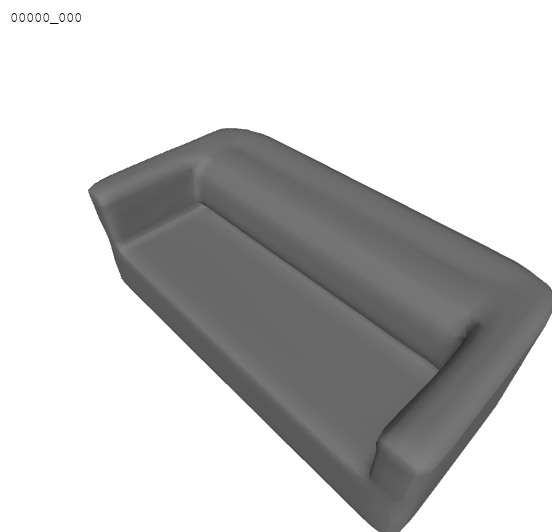

In [19]:
from exercise_3.util.mesh_collection_to_gif import  meshes_to_gif
from exercise_3.util.misc import show_gif

# create list of meshes (just exported) to be visualized
mesh_paths = sorted([x for x in Path("exercise_3/runs/3_2_deepsdf_generalization/interpolation").iterdir() if int(x.name.split('.')[0].split("_")[1]) == 0], key=lambda x: int(x.name.split('.')[0].split("_")[0]))
mesh_paths = mesh_paths + mesh_paths[::-1]

# create a visualization of the interpolation process
meshes_to_gif(mesh_paths, "exercise_3/runs/3_2_deepsdf_generalization/latent_interp.gif", 20)
show_gif("exercise_3/runs/3_2_deepsdf_generalization/latent_interp.gif")

## Submission

This is the end of exercise 3 🙂. Please create a zip containing all files we provided, everything you modified, your visualization images/gif (no need to submit generated OBJs), including your checkpoints. Name it with your matriculation number(s) as described in exercise 1. Make sure this notebook can be run without problems. Then, submit via Moodle.

**Note**: The maximum submission file size limit for Moodle is 100M. You do not need to submit your overfitting checkpoints; however, the generalization checkpoint will be >200M. The easiest way to still be able to submit that one is to split it with zip like this: `zip -s 100M model_best.ckpt.zip model_best.ckpt` which creates a `.zip` and a `.z01`. You can then submit both files alongside another zip containing all your code and outputs.

**Submission Deadline**: 13.06.2023, 23:55

## References

[1] Dai, Angela, Charles Ruizhongtai Qi, and Matthias Nießner. "Shape completion using 3d-encoder-predictor cnns and shape synthesis." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2017.

[2] Park, Jeong Joon, et al. "Deepsdf: Learning continuous signed distance functions for shape representation." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2019.